In [3]:
%pylab inline
#from ctypes import" *
import ctypes
import os
PSH=ctypes.cdll.LoadLibrary('pshmf.so')


Populating the interactive namespace from numpy and matplotlib


In [4]:
pwd

'/Users/dfy/work/sjtu/8100/power_spec_gadget/python-eps'

In [5]:
#initiallize for calculating sig(M):
z1   = 0.02
z2   = 0.
m2   = 13
M2   = 10.**m2/1e10
M1   = 10.**np.arange(m2-2,m2,0.002)/1e10 #M1<M2, z1>z2 (S1>S2, dc1>dc2) P(M1,z1|M2,z2)
S1   = np.zeros(M1.shape[0],dtype=np.double)
temp = np.zeros(3,dtype=np.double)

#initiallize for calculating dc:
zmin,zmax,nz = 0,0.1,1000
zstep = (zmax-zmin)/nz
zz    = zstep*np.arange(nz) + zmin 
dc    = np.zeros(nz,dtype=np.double)

In [6]:
#make a dc(z) table
PSH.dc_redshift(np.ctypeslib.as_ctypes(dc),
                np.ctypeslib.as_ctypes(zz),
                ctypes.c_int(nz)
               )

0

In [7]:
PSH.prepare()
PSH.sig_M1_M2_z1_z2.restype = None
PSH.sig_M1_M2_z1_z2(ctypes.c_double(M2),
               np.ctypeslib.as_ctypes(M1),
               np.ctypeslib.as_ctypes(S1),
               ctypes.c_int(M1.shape[0]),
               ctypes.c_double(z2),
               ctypes.c_double(z1),
               np.ctypeslib.as_ctypes(temp)
               )
S2,DZ1,DZ2 = temp[0],temp[1],temp[2]


In [8]:
M1,M2 = M1*1e10,M2*1e10
print(DZ1,DZ2)
print(np.log10(M1).max(),np.log10(M1).min())

1.0 1.0096916398366378
12.998000000000667 11.0


In [72]:
median_m = lambda x:0.5*(x[1:]+x[:-1])

def t_z(om0,ol0,zz):
    H0  = 72
    amp = 1./(365*24*3600.)
    print(amp)
    return 1./H0*2./3/np.sqrt(ol0)*np.log((np.sqrt(ol0*(1+zz)**(-3))+np.sqrt(ol0*(1+zz)**(-3)+om0))/np.sqrt(om0))*amp
def DtDz(om0,ol0,zz):
    tz = t_z(om0,ol0,zz)
    return (tz[1:]-tz[:-1])/(zz[1:]-zz[:-1])
    
def PS(sigma):
    return np.sqrt(2./np.pi)*dc/sigma*np.exp(-dc**2./2/sigma**2.)
def ST(sigma):
    A,a,p=0.3222,0.707,0.3
    return A*np.sqrt(2*a/np.pi)*(1+(sigma**2/a/dc**2)**p)*dc/sigma*np.exp(-a*dc**2./2/sigma**2.)
def eps_merger_rate(M1,M2,S1,S2,DZ,dc,dcdt):
    dSdM = np.abs( (np.log(S2[1:])-np.log(S2[:-1]))/(np.log(M2[1:])-np.log(M2[:-1])) )
    s2   = S2[1:]
    #s2   = median_m(S2)
    amp  = 1./np.sqrt(2*np.pi)*np.abs(dcdt)*dc/np.sqrt(s2)
    '''
    print(amp)
    print(dSdM)
    print((S1/(S1-s2))**(3./2))
    print(exp(-dc*dc*(S1-s2)/2/S1/s2))
    '''
    return amp * (S1/(S1-s2))**(3./2)*exp(-dc*dc*(S1-s2)/2/S1/s2)*dSdM

def conditional_M1_M2(dc1,dc2,S1,S2): #P(M1,z1|M2,z2)
    return 1./np.sqrt(2*np.pi)*(dc1-dc2)/(S1-S2)**(3./2)*exp(-(dc1-dc2)**2/2/(S1-S2))

def conditional_M2_M1(dc1,dc2,S1,S2): #P(M2,z2|M1,z1)
    return 1./np.sqrt(2*np.pi)*dc2*(dc1-dc2)/dc1*(S1/S2/(S1-S2))**(3./2)*exp((dc2*S1-dc1*S2)**2./(2*S1*S2*(S1-S2)))

def P_M1_M2(dc1,dc2,S1,S2): #z1>z2, projenitor halo mass function for a given M2(z2)
    return 1./np.sqrt(2*np.pi)*(dc1-dc2)/(S1-S2)**(3./2)*np.exp(-(dc1-dc2)*(dc1-dc2)/2/(S1-S2))

def OF_rate(S1,S2,dcdz): #Onsi Fakhouri, 2008, EPS,EQ(10)
    sigm1,sigm2 = np.sqrt(S1),np.sqrt(S2)
    return np.sqrt(2./np.pi)*dcdz/median_m(sigm1)*np.abs((np.log(sigm1)-np.log(sigm2))/(np.log(M1[1:])-np.log(M1[:-1])))*(1-S2/S1)**(-3./2)

def OF_fit_rate(M0,zz,zmin,zstep,dcdt):
    xi   = 10.**np.arange(-3,0,0.1)
    A,a1,a2,a3,a4 = 0.0289,0.083,-2.01,0.409,0.371
    am,axi = 1.2*1e12,0.098
    iz   = np.int32(np.floor((zz-zmin)/zstep))
    dcdz = dcdt[iz]
    print(iz)
    return xi,A*(M0/am)**(a1)*xi**(a2)*np.exp((xi/axi)**(a3))*(dcdz)**(a4) 

def OF_fit_rate2(M0,zz,zmin,zstep,dcdt):
    xi = 10.**np.arange(-3,0,0.1)
    A,a,b,r,y,axi = 0.0104,0.133,-1.995,0.263,0.0993,9.72*1e-3
    return A*(M0/1e12)**a*xi**b*np.exp((xi/axi)**r)*(1+zz)**y

def OF_dMmean_dt(M0,zz,zmin,zstep,om0,ol0,dtdz): #undo
    return 25.3*(M0/1e12)**(1.1)*(1+1.65*zz)*np.sqrt(om0*(1+zz)**3+ol0)

def OF_dMmean_dz(M0,zz,zmin,zstep,om0,ol0,dtdz): #undo
    dM_dt = OF_dMmean_dt(M0,zz,zmin,zstep,om0,ol0,dtdz)
    iz = np.int32(np.floor((zz-zmin)/zstep))
    return dM_dt*np.abs(dtdz[iz])#/(M0*np.log(10))


def jz_rate(M2,M1,S2,S1,dcdz): #jz,2006, EQ(17)
    dS = median_m(S1)-S2
    return median_m(M1)/(M2-median_m(M1)),dcdz*M2*M2/(1+median_m(M1)/(M2-median_m(M1)))**2./median_m(M1)*(S1[1:]-S1[:-1])/(M1[1:]-M1[:-1])/np.sqrt(2*np.pi)/dS**(3./2)

def Mmax_M1(M1,M2):
    Ma = np.zeros(M1.shape[0])
    for i in np.arange(M1.shape[0]):
        Ma[i] = np.max((M1[i],M2-M1[i]))
    return Ma


In [73]:
dMt = OF_dMmean_dt(M2,z1,zmin,zstep,om0,ol0,dtdz)
dMz = OF_dMmean_dz(M2,z1,zmin,zstep,om0,ol0,dtdz)
print(dMt,dMz,z1,M2/1e12)

331.7064915103144 1.4205330548558957e-07 0.02 10.0


3.1709791983764586e-08


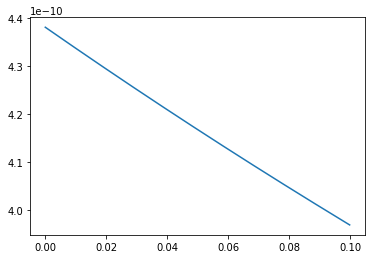

In [62]:
plt.plot(zz,t_z(om0,ol0,zz))

z1= 0.02 z2= 0.0 dc1= 1.7023401047645712 dc2= 1.686


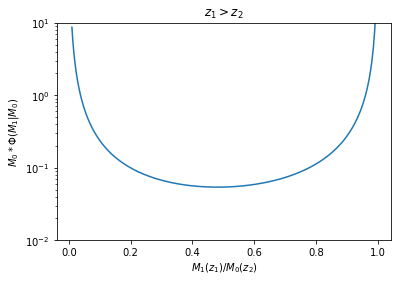

In [42]:
#The projenitor halo mass function for a given M2(z2)
dcdt = (dc[1:]-dc[:-1])/(zz[1:]-zz[:-1])
idc1 = np.int32(np.floor((z1-zmin)/zstep))
idc2 = np.int32(np.floor((z2-zmin)/zstep))

Pm1m2 = P_M1_M2(dc[idc1],dc[idc2],S1,S2)
plt.plot((M1/M2)[1:],(Pm1m2*M2/M1)[1:]*(S1[:-1]-S1[1:])/(M1[1:]-M1[:-1])*M2)
plt.yscale('log')
plt.ylim(1e-2,10)
plt.ylabel(r'$M_0*\Phi(M_1\vert M_0)$')
plt.xlabel(r'$M_1(z_1)/M_0(z_2)$')
plt.title(r'$z_1>z_2$')
print('z1=',z1,'z2=',z2,'dc1=',dc[idc1],'dc2=',dc[idc2])

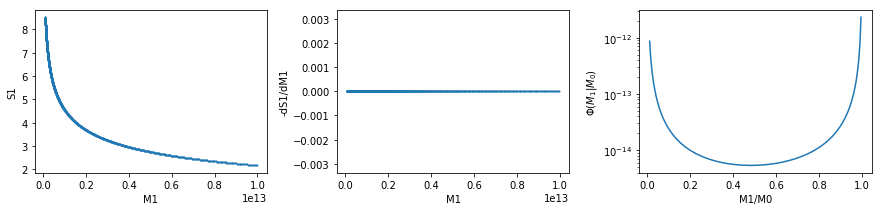

In [43]:
#The projenitor halo mass function for a given M2(z2)
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.scatter(M1,S1,s=1)
plt.ylabel('S1')
#plt.ylabel(r'$\sigma_M$')
plt.xlabel('M1')
plt.subplot(132)
plt.scatter(median_m(M1),-(S1[1:]-S1[:-1])/(M1[1:]-M1[:-1]),s=1)
#plt.plot(M1[1:]*1e10,-2*(np.sqrt(S1[1:])-np.sqrt(S1[:-1]))/(M1[1:]-M1[:-1]),ls='--')
#plt.yscale('log')
plt.xlabel('M1')
plt.ylabel('-dS1/dM1')
plt.subplot(133)
plt.plot(M1[1:]/M2,-M2/M1[1:]*(S1[1:]-S1[:-1])/(M1[1:]-M1[:-1])*Pm1m2[1:])
plt.xlabel('M1/M0')
plt.ylabel(r'$\Phi(M_1\vert M_0)$')
plt.yscale('log')
plt.subplots_adjust(wspace=0.3)

In [44]:
#for a M0, the projenitor halo merger rate, jz, M1<dM:
index = np.where(M1<=M2/2.)
M3  = M1[index].copy()
S3  = S1[index].copy()
Pm1m3 = Pm1m2[index].copy()
dM  = M2-M3
idcdt = np.int32(np.floor((z1-zmin)/zstep))
xi,jzr = jz_rate(M2,M3,S2,S3,dcdt[idcdt])
xioff,off = OF_fit_rate(M2,z1,zmin,zstep,dcdt)

200


In [45]:
print(xioff)
print(off)
print(M2,z1,zmin,zstep)
#print(dcdt)

[0.001      0.00125893 0.00158489 0.00199526 0.00251189 0.00316228
 0.00398107 0.00501187 0.00630957 0.00794328 0.01       0.01258925
 0.01584893 0.01995262 0.02511886 0.03162278 0.03981072 0.05011872
 0.06309573 0.07943282 0.1        0.12589254 0.15848932 0.19952623
 0.25118864 0.31622777 0.39810717 0.50118723 0.63095734 0.79432823]
[4.00398052e+04 2.55898275e+04 1.63791779e+04 1.05009915e+04
 6.74454149e+03 4.34046132e+03 2.79940506e+03 1.80982028e+03
 1.17313420e+03 7.62632508e+02 4.97350172e+02 3.25480359e+02
 2.13822066e+02 1.41061963e+02 9.34926937e+01 6.22808172e+01
 4.17213107e+01 2.81208387e+01 1.90822079e+01 1.30451283e+01
 8.99094592e+00 6.25243281e+00 4.39099672e+00 3.11723355e+00
 2.23939695e+00 1.62988685e+00 1.20339406e+00 9.02603349e-01
 6.88810929e-01 5.35746272e-01]
10000000000000.0 0.02 0 0.0001


200
200
200


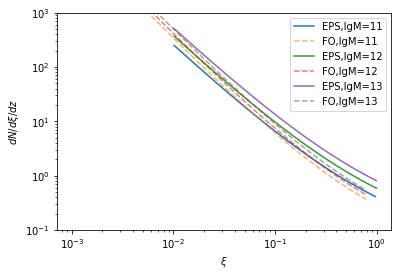

In [25]:
mstr = np.array([11,12,13,14])
#for i in np.arange(mstr.shape[0]):
for i in np.arange(3):
    xxi = np.loadtxt('temp/jzeps-m'+np.str(mstr[i])+'-rate.dat')
    xioff,off = OF_fit_rate(10.**mstr[i],z1,zmin,zstep,dcdt)
    plt.loglog(xxi[0],xxi[1],label='EPS,lgM='+np.str(mstr[i]))
    plt.loglog(xioff,off,label='FO,lgM='+np.str(mstr[i]),ls='--',alpha=0.6)
    
#plt.loglog(xi,-jzr,label='EPS')
#plt.loglog(xioff,off,label='FO,lgM='+np.str(mstr[i]),ls='--',alpha=0.6)
plt.ylim(1e-1,1e3)
plt.xlabel(r'$\xi$')
plt.ylabel(r'$dN/d\xi/dz$')
plt.legend()
#np.savetxt('temp/jzeps-m'+np.str(np.int32(np.floor(m2)))+'-rate.dat',np.vstack((xi,-jzr)))

In [67]:
om0,ol0 = 0.268,0.732
dtdz = DtDz(0.268,0.732,zz)
OF_fit_rate2(M2,z1,zmin,zstep,dcdt)/OF_Mmean(M2,z1,zmin,zstep,om0,ol0,dtdz)

3.1709791983764586e-08


array([1.66814025e+11, 1.09053709e+11, 7.14461792e+10, 4.69144214e+10,
       3.08804940e+10, 2.03787816e+10, 1.34852179e+10, 8.94947439e+09,
       5.95765767e+09, 3.97901498e+09, 2.66677510e+09, 1.79391687e+09,
       1.21150036e+09, 8.21592668e+08, 5.59647338e+08, 3.83016407e+08,
       2.63446864e+08, 1.82170080e+08, 1.26681599e+08, 8.86248671e+07,
       6.23973144e+07, 4.42300324e+07, 3.15786299e+07, 2.27189914e+07,
       1.64782769e+07, 1.20554026e+07, 8.90087585e+06, 6.63610751e+06,
       4.99905343e+06, 3.80746901e+06])

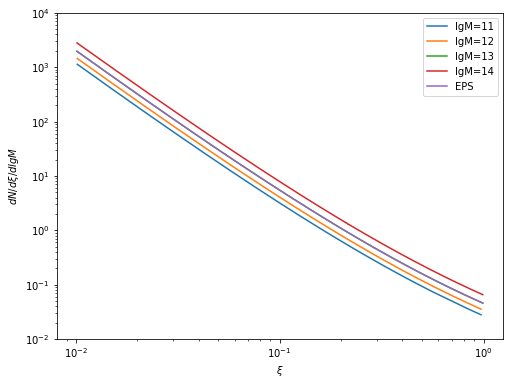

In [26]:
#mstr = np.array(['11.5','12','12.5','13','13.5','14'])
plt.figure(figsize=(8,6))
mstr = np.array(['11','12','13','14'])
for i in np.arange(mstr.shape[0]):
    xxi = np.loadtxt('temp/jzeps-m'+mstr[i]+'-dlgM.dat')
    plt.loglog(xxi[0],xxi[1],label='lgM='+mstr[i])
    
xilgM = -jzr/(np.log10(M2)-median_m(np.log10(dM)))*(z1-z2)
#plt.loglog(xi,xilgM,label='EPS')
#plt.loglog(xioff,off,label='FO')
plt.ylim(1e-2,1e4)
plt.xlabel(r'$\xi$')
plt.ylabel(r'$dN/d\xi/dlgM$')
plt.legend()
#np.savetxt('temp/jzeps-m'+np.str(m2)+'-dlgM.dat',np.vstack((xi,xilgM)))

In [201]:
jzr.shape

(849,)

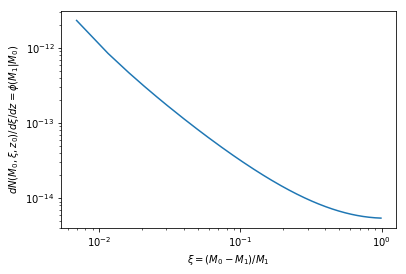

In [141]:
#for a M0, the projenitor halo merger rate, eps, Mo-P336-EQ(7.80):
index = np.where(M1>=M2/2.)
M3  = M1[index].copy()
S3  = S1[index].copy()
Pm1m3 = Pm1m2[index].copy()
dM  = M2-M3
plt.plot(median_m(dM/M3),-M2/M3[1:]*(S3[1:]-S3[:-1])/(M3[1:]-M3[:-1])*Pm1m3[1:])#/(np.log10(M2)-np.log10(M3[1:])))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\xi=(M_0-M_1)/M_1$')
plt.ylabel(r'$dN(M_0,\xi,z_0)/d\xi/dz=\phi(M_1\vert M_0)$')

In [ ]:
jz_rate(M2,xi,M1,dS):

In [133]:
idcdt = np.int32(np.floor(()))
OF_rate(S1,S2,dcdz)

NameError: name 'OF_rate' is not defined

In [112]:
M3

array([501.18723363, 503.50060879, 505.824662  , 508.15944256,
       510.50499998, 512.86138399, 515.22864458, 517.60683195,
       519.99599653, 522.396189  , 524.80746025, 527.22986142,
       529.66344389, 532.10825927, 534.5643594 , 537.03179637,
       539.51062252, 542.0008904 , 544.50265284, 547.01596289,
       549.54087386, 552.07743928, 554.62571296, 557.18574893,
       559.7576015 , 562.34132519, 564.93697481, 567.54460541,
       570.16427228, 572.79603099, 575.43993734, 578.09604741,
       580.76441752, 583.44510427, 586.13816451, 588.84365536,
       591.56163418, 594.29215862, 597.03528658, 599.79107626,
       602.55958608, 605.34087475, 608.13500128, 610.94202491,
       613.76200517, 616.59500186, 619.44107508, 622.30028517,
       625.17269278, 628.05835881, 630.95734448, 633.86971126,
       636.79552091, 639.73483548, 642.68771732, 645.65422904,
       648.63443355, 651.62839406, 654.63617407, 657.65783736,
       660.69344801, 663.7430704 , 666.80676921, 669.88